In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import math
import missingno as msno
plt.rcParams['font.sans-serif'] = ['SimHei']  # 中文字体设置-黑体
plt.rcParams['axes.unicode_minus'] = False  # 解决保存图像是负号'-'显示为方块的问题
sns.set(font='SimHei')  # 解决Seaborn中文显示问题

In [2]:
'''
## 目标是根据人口普查核实数据
### 查看数据概览
#### 分别对各个数据中的字段进行合并，并进行整理
### 单变量分析
#### 新建两个集合，分别来计算把连续变量离散化和未离散化的数据
### 特征工程,数据清洗
### 双变量分析
* 结果标签观察
* 特征清洗分析
* 特征合并
* 特征构建
### 模型建立
'''
headers = ['age', 'workclass', 'fnlwgt', 
           'education', 'education-num', 
           'marital-status', 'occupation', 
           'relationship', 'race', 'sex', 
           'capital-gain', 'capital-loss', 
           'hours-per-week', 'native-country', 
           'predclass']
training_raw = pd.read_csv("dataset/adult.data",names=headers,header=None)
test_raw = pd.read_csv("dataset/adult.test",names=headers,header=None)

In [3]:
training_raw.describe()

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week
count,32561.000000,3.256100e+04,32561.000000,32561.000000,32561.000000,32561.000000
mean,38.581647,1.897784e+05,10.080679,1077.648844,87.303830,40.437456
std,13.640433,1.055500e+05,2.572720,7385.292085,402.960219,12.347429
min,17.000000,1.228500e+04,1.000000,0.000000,0.000000,1.000000
25%,28.000000,1.178270e+05,9.000000,0.000000,0.000000,40.000000
50%,37.000000,1.783560e+05,10.000000,0.000000,0.000000,40.000000
75%,48.000000,2.370510e+05,12.000000,0.000000,0.000000,45.000000
max,90.000000,1.484705e+06,16.000000,99999.000000,4356.000000,99.000000


In [4]:
training_raw.describe(include=['O'])

,workclass,education,marital-status,occupation,relationship,race,sex,native-country,predclass
count,32561,32561,32561,32561,32561,32561,32561,32561,32561
unique,9,16,7,15,6,5,2,42,2
top,Private,HS-grad,Married-civ-spouse,Prof-specialty,Husband,White,Male,United-States,<=50K
freq,22696,10501,14976,4140,13193,27816,21790,29170,24720


In [5]:
test_raw.head()


,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,predclass
0,|1x3 Cross validator,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,25,Private,226802.0,11th,7.0,Never-married,Machine-op-inspct,Own-child,Black,Male,0.0,0.0,40.0,United-States,<=50K.
2,38,Private,89814.0,HS-grad,9.0,Married-civ-spouse,Farming-fishing,Husband,White,Male,0.0,0.0,50.0,United-States,<=50K.
3,28,Local-gov,336951.0,Assoc-acdm,12.0,Married-civ-spouse,Protective-serv,Husband,White,Male,0.0,0.0,40.0,United-States,>50K.
4,44,Private,160323.0,Some-college,10.0,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688.0,0.0,40.0,United-States,>50K.


In [6]:
# 删除第一条错误数据
test_raw.drop(axis=0,index=0,inplace=True)
test_raw.age = test_raw.age.apply(np.float)
test_raw.describe()

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week
count,16281.000000,1.628100e+04,16281.000000,16281.000000,16281.000000,16281.000000
mean,38.767459,1.894357e+05,10.072907,1081.905104,87.899269,40.392236
std,13.849187,1.057149e+05,2.567545,7583.935968,403.105286,12.479332
min,17.000000,1.349200e+04,1.000000,0.000000,0.000000,1.000000
25%,28.000000,1.167360e+05,9.000000,0.000000,0.000000,40.000000
50%,37.000000,1.778310e+05,10.000000,0.000000,0.000000,40.000000
75%,48.000000,2.383840e+05,12.000000,0.000000,0.000000,45.000000
max,90.000000,1.490400e+06,16.000000,99999.000000,3770.000000,99.000000


## 目标是根据人口普查数据，预测年收入是否可以大于5w一年

In [7]:
# 合并进行分析
dataset_raw = training_raw.append(test_raw,ignore_index=True)
dataset_raw.age = dataset_raw.age.apply(np.int)



### 单变量分析

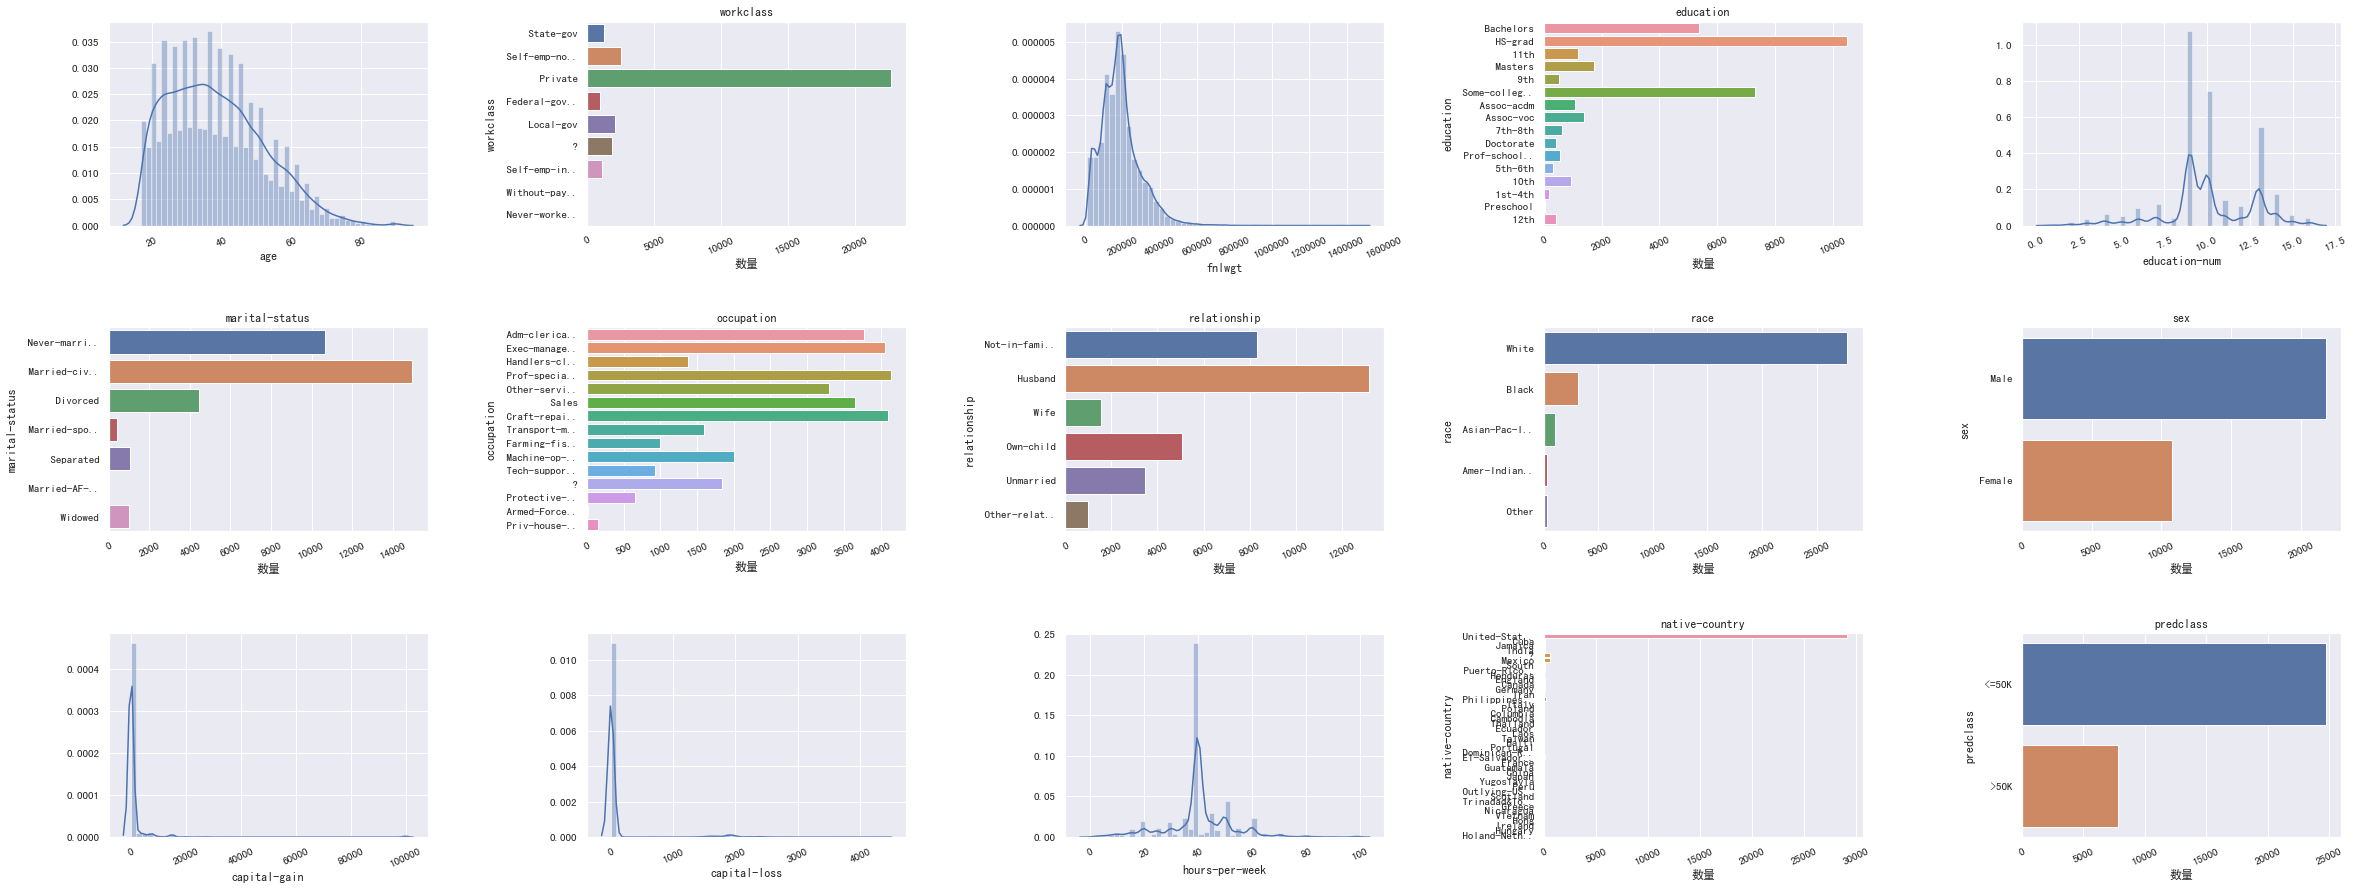

In [8]:
# 标签处理
def plot_distribution(dataset :pd.DataFrame,cols=3,width=40,height=15):
    rows = math.ceil(dataset.shape[1]/cols)
    plt.figure(figsize=(width,height))
    plt.subplots_adjust(wspace=0.5,hspace=0.5)
    for index,column in enumerate(dataset.columns):
        plt.subplot(rows,cols,index+1)
        plt.xticks(rotation=25)
        if dataset[column].dtype == np.object:
            g = sns.countplot(y=column,data=training_raw)
            g.set_title(column)
            g.set_xlabel("数量")
            g.set_yticklabels([i.get_text() if len(i.get_text()) < 12 else i.get_text()[0:12]+'..' for i  in g.get_yticklabels()])
        else:
            sns.distplot(training_raw[column])



plot_distribution(dataset=dataset_raw,cols=5)

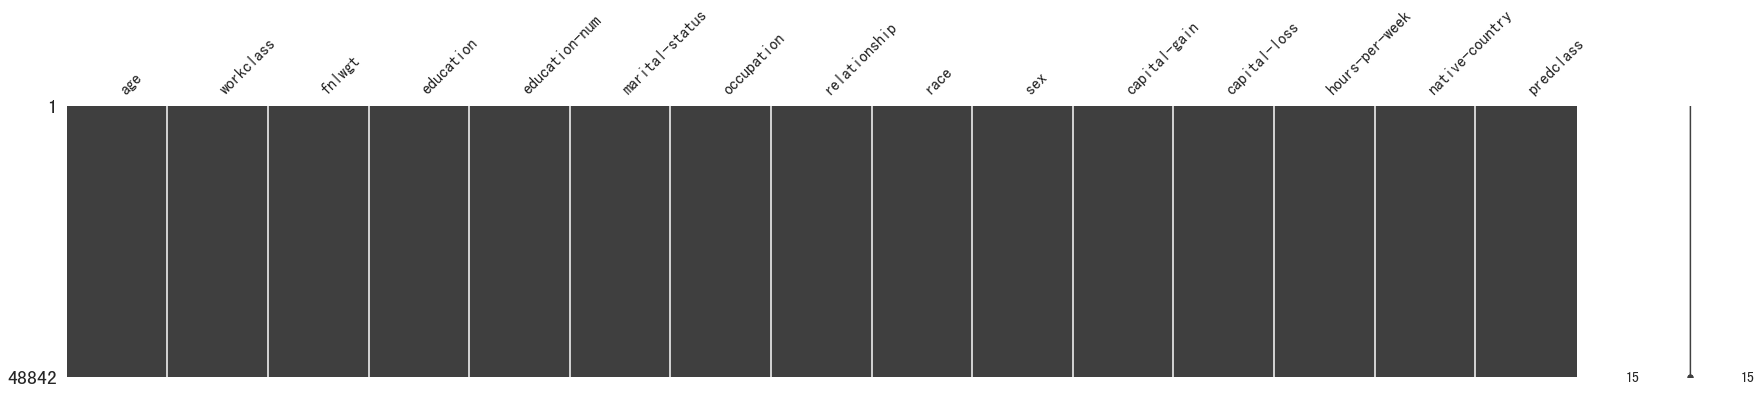

In [9]:
# 缺失值显示
msno.matrix(dataset_raw, figsize = (30,5))

#### 数据清洗
##### 清洗
* 缺失值: 对缺失值进行填充
* 特殊值: 一些错误导致的特殊值，例如 ±Inf, NA NaN
* 离群点: 这些点可能会对结果产生影响，先把它们找出来
* 错误值: 比如人的年龄不可能出现负数

##### 特征工程
* 连续变量的离散化
* 分类变量数据的合并
* 特征的降维处理
* 数据的归一化、标准化
* 构建性特征
* 特征分解: 比如将时间数据2014-09-20T20:45:40Z 转换成天，小时等信息.
* 离散化: 我们可以选择离散一些我们所拥有的连续变量，因为一些算法会执行得更快。但是会对结果产生什么样的影响呢？需要比较离散和非离散的建模结果
* dataset_bin => 连续值被离散化的数据集
* dataset_con => 非离散化的数据集
* 特征组合: 将不同的特征组合成一个新特征

##### 缺失值填充
* 均值
* 线性回归值
* 额外的数据补充: 有点难弄
* 均值填充: 这样可以不改变当前数据集整体的均值
* 回归模型预测: 建立一个回归模型去得到预测值

In [10]:
# 新建两个集合，分别来计算把连续变量离散化和未离散化的数据
# 分别对各个数据中的字段进行合并，并进行整理
# 离散变量数据集
dataset_bin = pd.DataFrame()
# 连续变量数据集
dataset_con = pd.DataFrame()

In [11]:
dataset_raw.predclass.unique()

array([' <=50K', ' >50K', ' <=50K.', ' >50K.'], dtype=object)

###### 标签处理，大于50k的为1 小于50k的为0

In [12]:
dataset_raw.loc[dataset_raw.predclass==' <=50K','predclass'] = 0
dataset_raw.loc[dataset_raw.predclass==' <=50K.','predclass'] = 0
dataset_raw.loc[dataset_raw.predclass==' >50K','predclass'] = 1
dataset_raw.loc[dataset_raw.predclass==' >50K.','predclass'] = 1


# 离散变量数据集
dataset_bin['predclass'] = dataset_raw['predclass']
# 连续变量数据集
dataset_con['predclass']  = dataset_raw['predclass']

dataset_raw.predclass.unique()


array([0, 1], dtype=int64)

### 开始处理变量

#### age处理离散化和不离散化

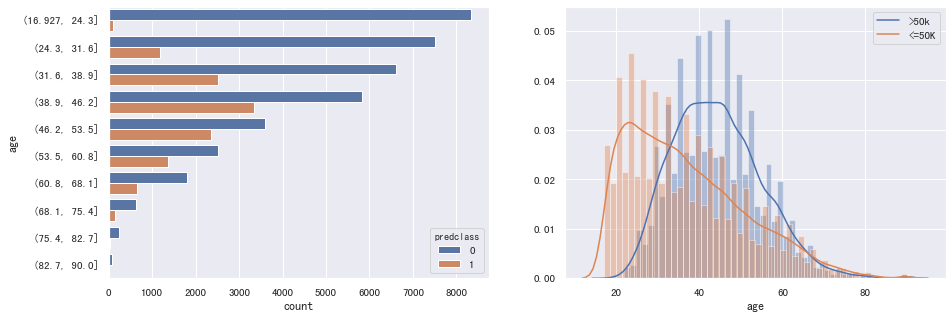

In [13]:
# 离散变量数据集
dataset_bin['age'] = pd.cut(dataset_raw['age'],10)
# 连续变量数据集
dataset_con['age']  = dataset_raw['age']


plt.figure(figsize=(15,5))
plt.subplot(121)
sns.countplot(data=dataset_bin,y='age',hue='predclass')
plt.subplot(122)
sns.distplot(dataset_con.loc[dataset_con.predclass==1,'age'],kde_kws={"label":">50k"})
sns.distplot(dataset_con.loc[dataset_con.predclass==0,'age'],kde_kws={"label": "<=50K"})

#### 处理workclass 工种

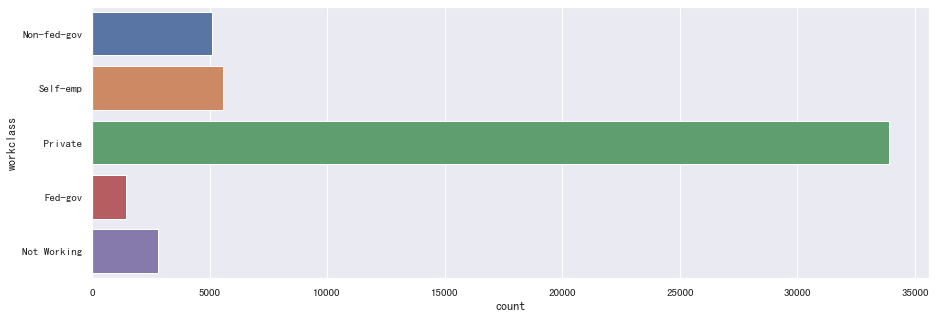

In [14]:

# sns.countplot(data=dataset_raw,y='workclass')

dataset_raw.loc[dataset_raw['workclass'] == ' Without-pay', 'workclass'] = 'Not Working'
dataset_raw.loc[dataset_raw['workclass'] == ' Never-worked', 'workclass'] = 'Not Working'
dataset_raw.loc[dataset_raw['workclass'] == ' Federal-gov', 'workclass'] = 'Fed-gov'
dataset_raw.loc[dataset_raw['workclass'] == ' State-gov', 'workclass'] = 'Non-fed-gov'
dataset_raw.loc[dataset_raw['workclass'] == ' Local-gov', 'workclass'] = 'Non-fed-gov'
dataset_raw.loc[dataset_raw['workclass'] == ' Self-emp-not-inc', 'workclass'] = 'Self-emp'
dataset_raw.loc[dataset_raw['workclass'] == ' Self-emp-inc', 'workclass'] = 'Self-emp'
dataset_raw.loc[dataset_raw['workclass'] == ' ?', 'workclass'] = 'Not Working'
dataset_raw.workclass.unique()
plt.figure(figsize=(15,5))
sns.countplot(data=dataset_raw,y='workclass')

dataset_con['workclass']=dataset_raw.workclass
dataset_bin['workclass']=dataset_raw.workclass

#### 特征: Occupation

array([' Adm-clerical', ' Exec-managerial', ' Handlers-cleaners',
       ' Prof-specialty', ' Other-service', ' Sales', ' Craft-repair',
       ' Transport-moving', ' Farming-fishing', ' Machine-op-inspct',
       ' Tech-support', ' ?', ' Protective-serv', ' Armed-Forces',
       ' Priv-house-serv'], dtype=object)

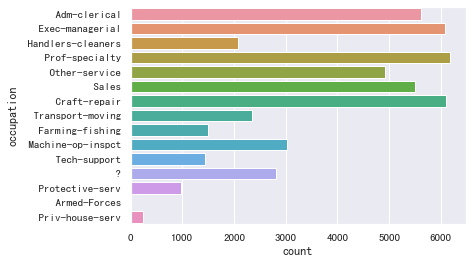

In [15]:
sns.countplot(data=dataset_raw,y='occupation')
dataset_raw.occupation.unique()

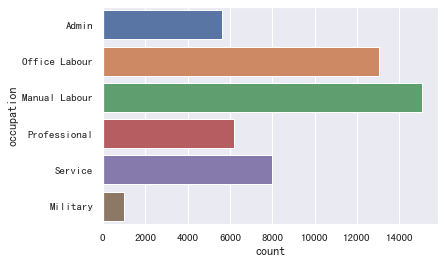

In [16]:
#  数量比较多，合并一些差不都的属性
dataset_raw.loc[dataset_raw['occupation'] == ' Adm-clerical', 'occupation'] = 'Admin'
dataset_raw.loc[dataset_raw['occupation'] == ' Armed-Forces', 'occupation'] = 'Military'
dataset_raw.loc[dataset_raw['occupation'] == ' Craft-repair', 'occupation'] = 'Manual Labour'
dataset_raw.loc[dataset_raw['occupation'] == ' Exec-managerial', 'occupation'] = 'Office Labour'
dataset_raw.loc[dataset_raw['occupation'] == ' Farming-fishing', 'occupation'] = 'Manual Labour'
dataset_raw.loc[dataset_raw['occupation'] == ' Handlers-cleaners', 'occupation'] = 'Manual Labour'
dataset_raw.loc[dataset_raw['occupation'] == ' Machine-op-inspct', 'occupation'] = 'Manual Labour'
dataset_raw.loc[dataset_raw['occupation'] == ' Other-service', 'occupation'] = 'Service'
dataset_raw.loc[dataset_raw['occupation'] == ' Priv-house-serv', 'occupation'] = 'Service'
dataset_raw.loc[dataset_raw['occupation'] == ' Prof-specialty', 'occupation'] = 'Professional'
dataset_raw.loc[dataset_raw['occupation'] == ' Protective-serv', 'occupation'] = 'Military'
dataset_raw.loc[dataset_raw['occupation'] == ' Sales', 'occupation'] = 'Office Labour'
dataset_raw.loc[dataset_raw['occupation'] == ' Tech-support', 'occupation'] = 'Office Labour'
dataset_raw.loc[dataset_raw['occupation'] == ' Transport-moving', 'occupation'] = 'Manual Labour'
dataset_raw.loc[dataset_raw['occupation'] == ' ?', 'occupation'] = 'Service'

sns.countplot(data=dataset_raw,y='occupation')

dataset_con['occupation']=dataset_raw.occupation
dataset_bin['occupation']=dataset_raw.occupation

##### 特征：Native Country

array([' United-States', ' Cuba', ' Jamaica', ' India', ' ?', ' Mexico',
       ' South', ' Puerto-Rico', ' Honduras', ' England', ' Canada',
       ' Germany', ' Iran', ' Philippines', ' Italy', ' Poland',
       ' Columbia', ' Cambodia', ' Thailand', ' Ecuador', ' Laos',
       ' Taiwan', ' Haiti', ' Portugal', ' Dominican-Republic',
       ' El-Salvador', ' France', ' Guatemala', ' China', ' Japan',
       ' Yugoslavia', ' Peru', ' Outlying-US(Guam-USVI-etc)', ' Scotland',
       ' Trinadad&Tobago', ' Greece', ' Nicaragua', ' Vietnam', ' Hong',
       ' Ireland', ' Hungary', ' Holand-Netherlands'], dtype=object)

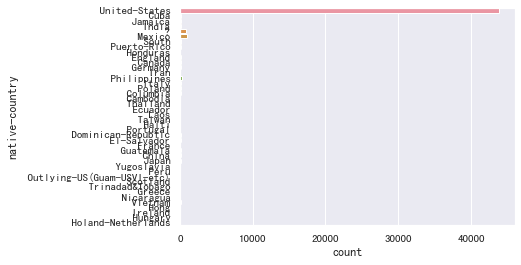

In [17]:
sns.countplot(data=dataset_raw,y='native-country')
dataset_raw['native-country'].unique()

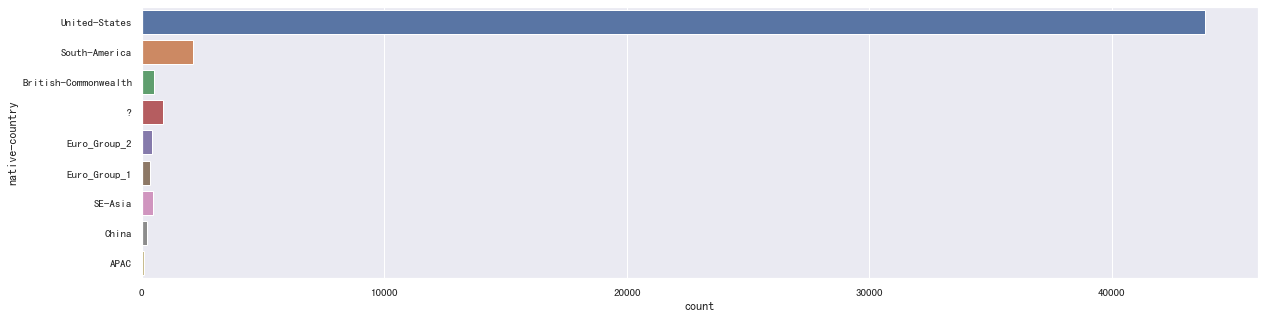

In [18]:
dataset_raw.loc[dataset_raw['native-country'] == ' Cambodia'                    , 'native-country'] = 'SE-Asia'
dataset_raw.loc[dataset_raw['native-country'] == ' Canada'                      , 'native-country'] = 'British-Commonwealth'    
dataset_raw.loc[dataset_raw['native-country'] == ' China'                       , 'native-country'] = 'China'       
dataset_raw.loc[dataset_raw['native-country'] == ' Columbia'                    , 'native-country'] = 'South-America'    
dataset_raw.loc[dataset_raw['native-country'] == ' Cuba'                        , 'native-country'] = 'South-America'        
dataset_raw.loc[dataset_raw['native-country'] == ' Dominican-Republic'          , 'native-country'] = 'South-America'
dataset_raw.loc[dataset_raw['native-country'] == ' Ecuador'                     , 'native-country'] = 'South-America'     
dataset_raw.loc[dataset_raw['native-country'] == ' El-Salvador'                 , 'native-country'] = 'South-America' 
dataset_raw.loc[dataset_raw['native-country'] == ' England'                     , 'native-country'] = 'British-Commonwealth'
dataset_raw.loc[dataset_raw['native-country'] == ' France'                      , 'native-country'] = 'Euro_Group_1'
dataset_raw.loc[dataset_raw['native-country'] == ' Germany'                     , 'native-country'] = 'Euro_Group_1'
dataset_raw.loc[dataset_raw['native-country'] == ' Greece'                      , 'native-country'] = 'Euro_Group_2'
dataset_raw.loc[dataset_raw['native-country'] == ' Guatemala'                   , 'native-country'] = 'South-America'
dataset_raw.loc[dataset_raw['native-country'] == ' Haiti'                       , 'native-country'] = 'South-America'
dataset_raw.loc[dataset_raw['native-country'] == ' Holand-Netherlands'          , 'native-country'] = 'Euro_Group_1'
dataset_raw.loc[dataset_raw['native-country'] == ' Honduras'                    , 'native-country'] = 'South-America'
dataset_raw.loc[dataset_raw['native-country'] == ' Hong'                        , 'native-country'] = 'China'
dataset_raw.loc[dataset_raw['native-country'] == ' Hungary'                     , 'native-country'] = 'Euro_Group_2'
dataset_raw.loc[dataset_raw['native-country'] == ' India'                       , 'native-country'] = 'British-Commonwealth'
dataset_raw.loc[dataset_raw['native-country'] == ' Iran'                        , 'native-country'] = 'Euro_Group_2'
dataset_raw.loc[dataset_raw['native-country'] == ' Ireland'                     , 'native-country'] = 'British-Commonwealth'
dataset_raw.loc[dataset_raw['native-country'] == ' Italy'                       , 'native-country'] = 'Euro_Group_1'
dataset_raw.loc[dataset_raw['native-country'] == ' Jamaica'                     , 'native-country'] = 'South-America'
dataset_raw.loc[dataset_raw['native-country'] == ' Japan'                       , 'native-country'] = 'APAC'
dataset_raw.loc[dataset_raw['native-country'] == ' Laos'                        , 'native-country'] = 'SE-Asia'
dataset_raw.loc[dataset_raw['native-country'] == ' Mexico'                      , 'native-country'] = 'South-America'
dataset_raw.loc[dataset_raw['native-country'] == ' Nicaragua'                   , 'native-country'] = 'South-America'
dataset_raw.loc[dataset_raw['native-country'] == ' Outlying-US(Guam-USVI-etc)'  , 'native-country'] = 'South-America'
dataset_raw.loc[dataset_raw['native-country'] == ' Peru'                        , 'native-country'] = 'South-America'
dataset_raw.loc[dataset_raw['native-country'] == ' Philippines'                 , 'native-country'] = 'SE-Asia'
dataset_raw.loc[dataset_raw['native-country'] == ' Poland'                      , 'native-country'] = 'Euro_Group_2'
dataset_raw.loc[dataset_raw['native-country'] == ' Portugal'                    , 'native-country'] = 'Euro_Group_2'
dataset_raw.loc[dataset_raw['native-country'] == ' Puerto-Rico'                 , 'native-country'] = 'South-America'
dataset_raw.loc[dataset_raw['native-country'] == ' Scotland'                    , 'native-country'] = 'British-Commonwealth'
dataset_raw.loc[dataset_raw['native-country'] == ' South'                       , 'native-country'] = 'Euro_Group_2'
dataset_raw.loc[dataset_raw['native-country'] == ' Taiwan'                      , 'native-country'] = 'China'
dataset_raw.loc[dataset_raw['native-country'] == ' Thailand'                    , 'native-country'] = 'SE-Asia'
dataset_raw.loc[dataset_raw['native-country'] == ' Trinadad&Tobago'             , 'native-country'] = 'South-America'
dataset_raw.loc[dataset_raw['native-country'] == ' United-States'               , 'native-country'] = 'United-States'
dataset_raw.loc[dataset_raw['native-country'] == ' Vietnam'                     , 'native-country'] = 'SE-Asia'
dataset_raw.loc[dataset_raw['native-country'] == ' Yugoslavia'                  , 'native-country'] = 'Euro_Group_2'

dataset_bin['native-country'] = dataset_raw['native-country']
dataset_con['native-country'] = dataset_raw['native-country']
plt.figure(figsize=(20,5))
sns.countplot(data=dataset_raw,y='native-country')

#### 特征：Education

array([' Bachelors', ' HS-grad', ' 11th', ' Masters', ' 9th',
       ' Some-college', ' Assoc-acdm', ' Assoc-voc', ' 7th-8th',
       ' Doctorate', ' Prof-school', ' 5th-6th', ' 10th', ' 1st-4th',
       ' Preschool', ' 12th'], dtype=object)

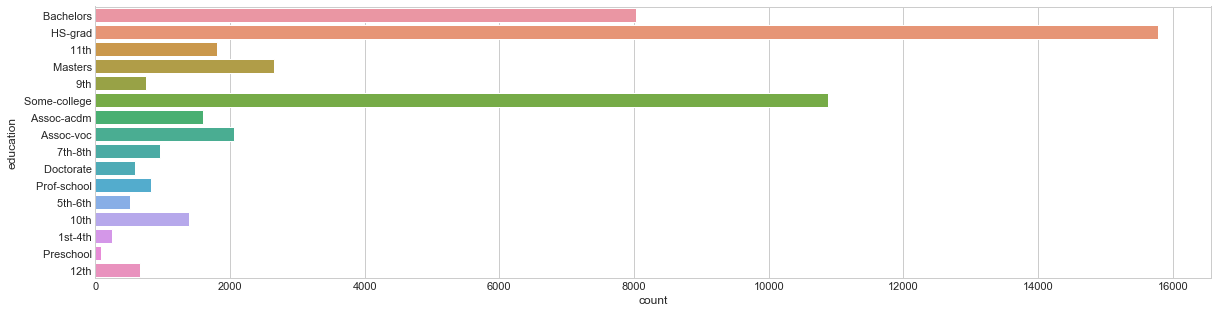

In [19]:
# 教育也进行合并
plt.style.use('seaborn-whitegrid')
plt.figure(figsize=(20,5)) 
sns.countplot(y="education", data=dataset_raw)
dataset_raw.education.unique()

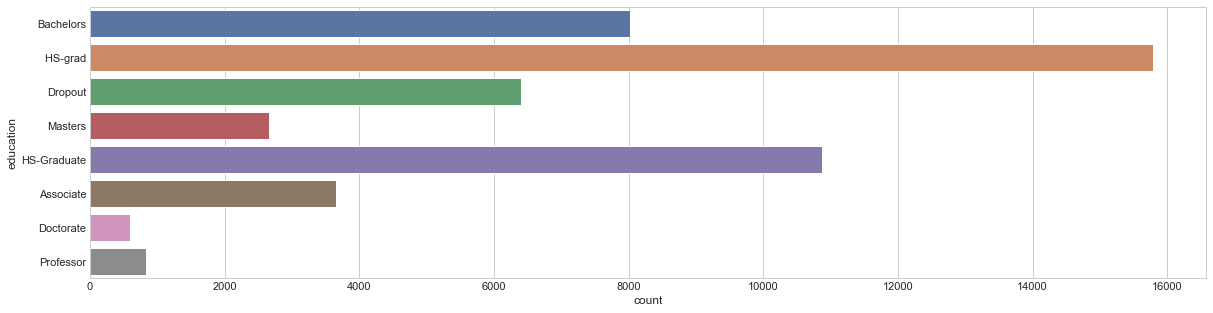

In [20]:
dataset_raw.loc[dataset_raw['education'] == ' 10th'          , 'education'] = 'Dropout'
dataset_raw.loc[dataset_raw['education'] == ' 11th'          , 'education'] = 'Dropout'
dataset_raw.loc[dataset_raw['education'] == ' 12th'          , 'education'] = 'Dropout'
dataset_raw.loc[dataset_raw['education'] == ' 1st-4th'       , 'education'] = 'Dropout'
dataset_raw.loc[dataset_raw['education'] == ' 5th-6th'       , 'education'] = 'Dropout'
dataset_raw.loc[dataset_raw['education'] == ' 7th-8th'       , 'education'] = 'Dropout'
dataset_raw.loc[dataset_raw['education'] == ' 9th'           , 'education'] = 'Dropout'
dataset_raw.loc[dataset_raw['education'] == ' Assoc-acdm'    , 'education'] = 'Associate'
dataset_raw.loc[dataset_raw['education'] == ' Assoc-voc'     , 'education'] = 'Associate'
dataset_raw.loc[dataset_raw['education'] == ' Bachelors'     , 'education'] = 'Bachelors'
dataset_raw.loc[dataset_raw['education'] == ' Doctorate'     , 'education'] = 'Doctorate'
dataset_raw.loc[dataset_raw['education'] == ' HS-Grad'       , 'education'] = 'HS-Graduate'
dataset_raw.loc[dataset_raw['education'] == ' Masters'       , 'education'] = 'Masters'
dataset_raw.loc[dataset_raw['education'] == ' Preschool'     , 'education'] = 'Dropout'
dataset_raw.loc[dataset_raw['education'] == ' Prof-school'   , 'education'] = 'Professor'
dataset_raw.loc[dataset_raw['education'] == ' Some-college'  , 'education'] = 'HS-Graduate'

dataset_bin['education'] = dataset_raw['education']
dataset_con['education'] = dataset_raw['education']
plt.figure(figsize=(20,5)) 
sns.countplot(y="education", data=dataset_raw)

#### 特征： Marital Status

array([' Never-married', ' Married-civ-spouse', ' Divorced',
       ' Married-spouse-absent', ' Separated', ' Married-AF-spouse',
       ' Widowed'], dtype=object)

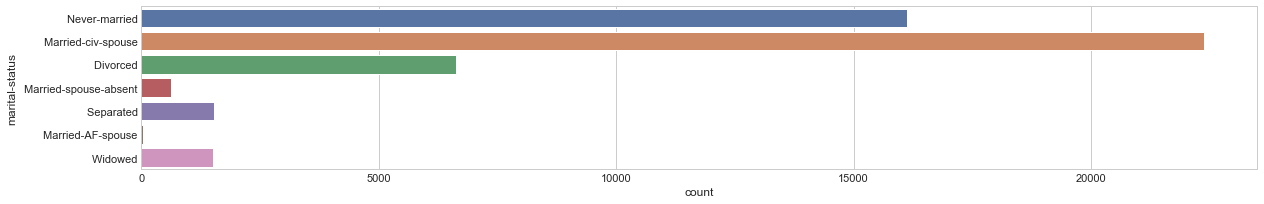

In [21]:
# 婚姻状况
plt.figure(figsize=(20,3)) 
sns.countplot(y="marital-status", data=dataset_raw);
dataset_raw['marital-status'].unique()

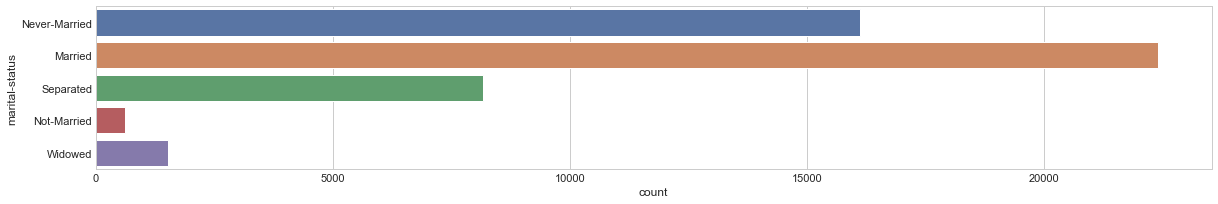

In [22]:
dataset_raw.loc[dataset_raw['marital-status'] == ' Never-married'        , 'marital-status'] = 'Never-Married'
dataset_raw.loc[dataset_raw['marital-status'] == ' Married-AF-spouse'    , 'marital-status'] = 'Married'
dataset_raw.loc[dataset_raw['marital-status'] == ' Married-civ-spouse'   , 'marital-status'] = 'Married'
dataset_raw.loc[dataset_raw['marital-status'] == ' Married-spouse-absent', 'marital-status'] = 'Not-Married'
dataset_raw.loc[dataset_raw['marital-status'] == ' Separated'            , 'marital-status'] = 'Separated'
dataset_raw.loc[dataset_raw['marital-status'] == ' Divorced'             , 'marital-status'] = 'Separated'
dataset_raw.loc[dataset_raw['marital-status'] == ' Widowed'              , 'marital-status'] = 'Widowed'

dataset_bin['marital-status'] = dataset_raw['marital-status']
dataset_con['marital-status'] = dataset_raw['marital-status']

plt.figure(figsize=(20,3)) 
sns.countplot(y="marital-status", data=dataset_raw)


#### 特征： Final Weight

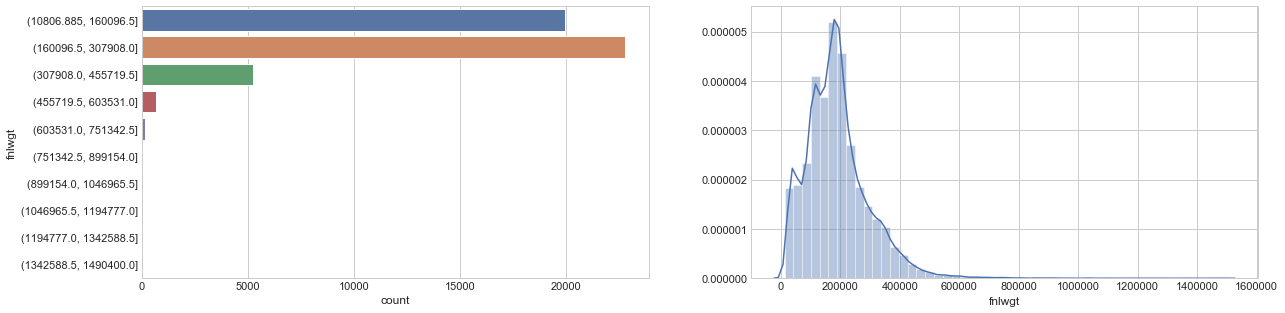

In [23]:
# 同样分成10份
dataset_bin['fnlwgt'] = pd.cut(dataset_raw['fnlwgt'], 10)
dataset_con['fnlwgt'] = dataset_raw['fnlwgt']

plt.figure(figsize=(20,5))
plt.subplot(121)
sns.countplot(y="fnlwgt", data=dataset_bin)
plt.subplot(122)
sns.distplot(dataset_con['fnlwgt'])

#### 特征： Hours per Week

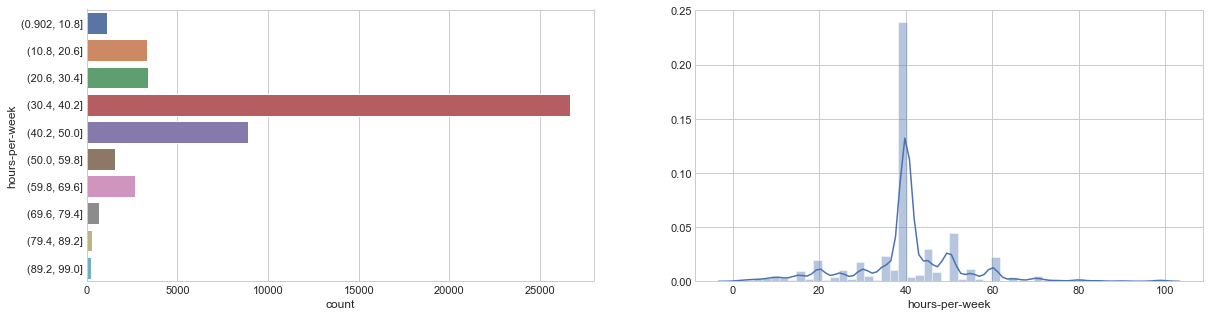

In [24]:
dataset_bin['hours-per-week'] = pd.cut(dataset_raw['hours-per-week'], 10)
dataset_con['hours-per-week'] = dataset_raw['hours-per-week']

plt.figure(figsize=(20,5))
plt.subplot(121)
sns.countplot(y="hours-per-week", data=dataset_bin)
plt.subplot(122)
sns.distplot(dataset_con['hours-per-week'])

#### 特征： 资本增益

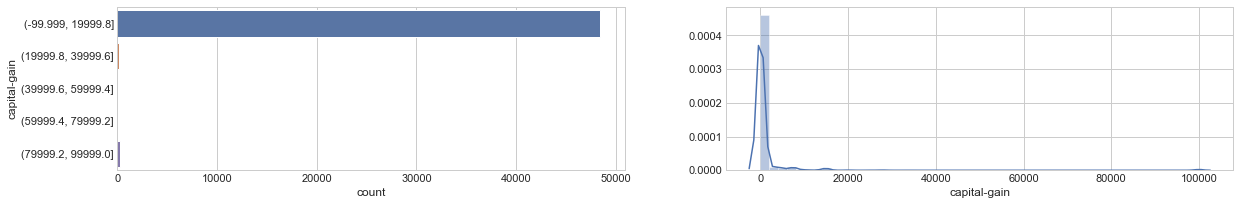

In [25]:
#资本增益
dataset_bin['capital-gain'] = pd.cut(dataset_raw['capital-gain'], 5)
dataset_con['capital-gain'] = dataset_raw['capital-gain']

plt.style.use('seaborn-whitegrid')
fig = plt.figure(figsize=(20,3)) 
plt.subplot(1, 2, 1)
sns.countplot(y="capital-gain", data=dataset_bin)
plt.subplot(1, 2, 2)
sns.distplot(dataset_con['capital-gain'])

#### 特征：资本损失

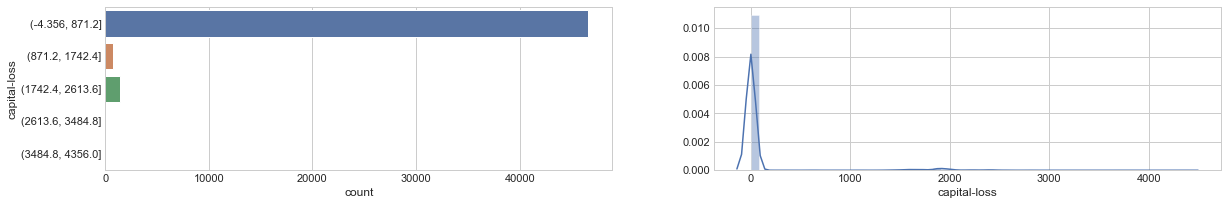

In [26]:
# 资本损失
dataset_bin['capital-loss'] = pd.cut(dataset_raw['capital-loss'], 5)
dataset_con['capital-loss'] = dataset_raw['capital-loss']

plt.style.use('seaborn-whitegrid')
fig = plt.figure(figsize=(20,3)) 
plt.subplot(1, 2, 1)
sns.countplot(y="capital-loss", data=dataset_bin)
plt.subplot(1, 2, 2)
sns.distplot(dataset_con['capital-loss'])

#### 剩余的特征：sex，race，relationship

In [27]:
# 这些就直接用了
dataset_con['sex'] = dataset_bin['sex'] = dataset_raw['sex']
dataset_con['race'] = dataset_bin['race'] = dataset_raw['race']
dataset_con['relationship'] = dataset_bin['relationship'] = dataset_raw['relationship']

### 双变量分析
看特征之间的相互关系

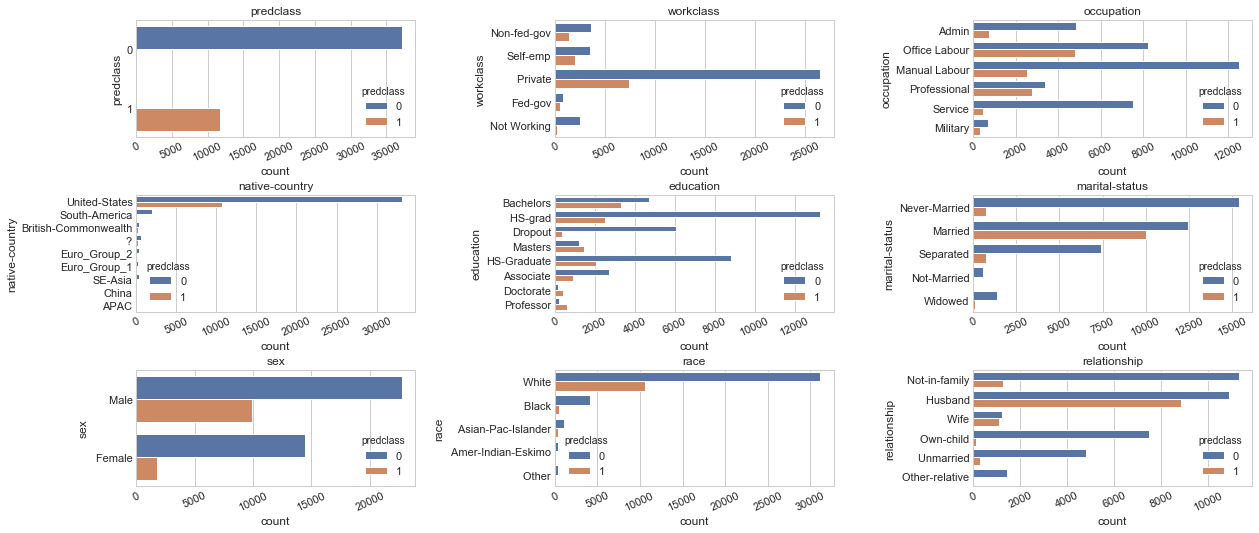

In [64]:
def plot_bivariate_bar(dataset :pd.DataFrame,hue,cols=3,width=20,height=15):
    rows = math.ceil(dataset.shape[1]/cols)
    plt.figure(figsize=(width,height))
    plt.style.use('seaborn-whitegrid')
    plt.subplots_adjust(wspace=0.5,hspace=0.5)
    dataset = dataset.select_dtypes(include='object')
    for index,column in enumerate(dataset.columns):
        plt.subplot(rows,cols,index+1)
        plt.xticks(rotation=25)
        if np.object == dataset.dtypes[column]:
            column
            g = sns.countplot(y=column,data=dataset,hue=hue)
            g.set_title(column)
# dataset_con.describe()
dataset_con['predclass'] = dataset_con['predclass'].astype(np.object)
dataset_bin['predclass'] = dataset_con['predclass'].astype(np.object)
plot_bivariate_bar(dataset_con,hue='predclass')
# dataset_con[['predclass','age','fnlwgt','hours-per-week','capital-gain','capital-loss']]
# dataset_con.dtypes
# 